## **Import Libraries**

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from math import sqrt

## **Loading the Data Object**

In [2]:
# Load the previously saved Data object
data = torch.load('data/graph_data.pt')

# print check
data

Data(x=[713, 4], edge_index=[2, 117780], edge_attr=[117780, 1], y=[453])

## **Define the GNN Model**

In [3]:
class SimpleGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)  # First GCN layer
        self.conv2 = GCNConv(16, num_classes)        # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # No log_softmax for regression

## **Initialise the Model and Optimiser**

In [4]:
num_node_features = 4  # From your Data object, x=[713, 4]
num_classes = 1  # Assuming a regression task; adjust based on your specific task

model = SimpleGCN(num_node_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Using Adam optimizer

## **Training, Validation and Test Set**

In [5]:
# Assuming the first 453 nodes have labels
num_labeled_nodes = 453  # Number of nodes with labels
train_proportion = 0.8
num_train = int(num_labeled_nodes * train_proportion)

# Generate masks
train_mask = torch.zeros(num_labeled_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_labeled_nodes, dtype=torch.bool)
indices = torch.randperm(num_labeled_nodes)
train_mask[indices[:num_train]] = True
test_mask[indices[num_train:]] = True

# Extend masks to cover all nodes, assuming unlabeled nodes are not used for training/testing
extended_train_mask = torch.cat((train_mask, torch.zeros(data.num_nodes - num_labeled_nodes, dtype=torch.bool)))
extended_test_mask = torch.cat((test_mask, torch.zeros(data.num_nodes - num_labeled_nodes, dtype=torch.bool)))

# Update data object
data.train_mask = extended_train_mask
data.test_mask = extended_test_mask

## **Training Loop**

This code assumes a regression task with mse_loss as the loss function. If you're performing a classification task, you'll need to adjust the loss function (e.g., using F.nll_loss for multi-class classification with log_softmax output).

The adjustments above are conceptual and rely on the assumption that your labeled data (data.y) directly corresponds to the first 453 nodes and that the masks (train_mask and test_mask) are correctly indicating which of these nodes are for training or testing. If your labeled nodes are scattered throughout the graph or if there's a different logic to which nodes are labeled, you'll need to adjust the indexing logic to correctly match the labeled nodes in data.y to their predictions in out.

In [6]:
def train():
    model.train()
    optimizer.zero_grad()

    out = model(data)  # This will output predictions for all nodes
    out = out.squeeze()  # Remove any singleton dimensions

    # Focus loss calculation on the labeled subset of nodes
    # Here, use the non-extended train mask to select the corresponding predictions
    train_loss = F.mse_loss(out[:num_labeled_nodes][train_mask], data.y[train_mask])

    train_loss.backward()
    optimizer.step()
    return train_loss.item()

In [7]:
def test():
    model.eval()
    with torch.no_grad():
        out = model(data)
        out = out.squeeze()  # Ensure output matches target dimension

        # Use the original (non-extended) test mask for labeled nodes
        test_loss = F.mse_loss(out[:num_labeled_nodes][test_mask], data.y[test_mask]).item()

    return test_loss

## **Execute the Training Loop, Calculate Loss**

In [8]:
num_epochs = 100  # Define the number of epochs for training

train_losses = []  # To store training loss per epoch
test_losses = []  # To store test loss per epoch

for epoch in range(num_epochs):
    train_loss = train()  # Train the model and get the training loss
    test_loss = test()  # Test the model and get the test loss
    
    # Optionally, print the losses to monitor the progress
    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    # Append losses for visualization/analysis
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch: 1/100, Train Loss: 206532.5156, Test Loss: 189078.1094
Epoch: 2/100, Train Loss: 199124.1562, Test Loss: 172115.4688
Epoch: 3/100, Train Loss: 173676.1250, Test Loss: 156888.7969
Epoch: 4/100, Train Loss: 163953.3906, Test Loss: 144157.4844
Epoch: 5/100, Train Loss: 162963.6406, Test Loss: 134515.0938
Epoch: 6/100, Train Loss: 146072.2031, Test Loss: 126551.7109
Epoch: 7/100, Train Loss: 147840.2812, Test Loss: 120540.3594
Epoch: 8/100, Train Loss: 148874.3281, Test Loss: 116318.8594
Epoch: 9/100, Train Loss: 158654.5781, Test Loss: 113360.5391
Epoch: 10/100, Train Loss: 160754.6562, Test Loss: 111495.3203
Epoch: 11/100, Train Loss: 148070.7031, Test Loss: 110564.1172
Epoch: 12/100, Train Loss: 158442.2500, Test Loss: 110112.6250
Epoch: 13/100, Train Loss: 143109.3906, Test Loss: 109884.6797
Epoch: 14/100, Train Loss: 152645.7812, Test Loss: 109914.6016
Epoch: 15/100, Train Loss: 136189.7500, Test Loss: 110079.2656
Epoch: 16/100, Train Loss: 154134.7656, Test Loss: 110528.0078
E

## **Evaluate the Model**

In [9]:
# Assuming test() function returns test loss and potentially other metrics
test_loss = test()
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 119992.5703


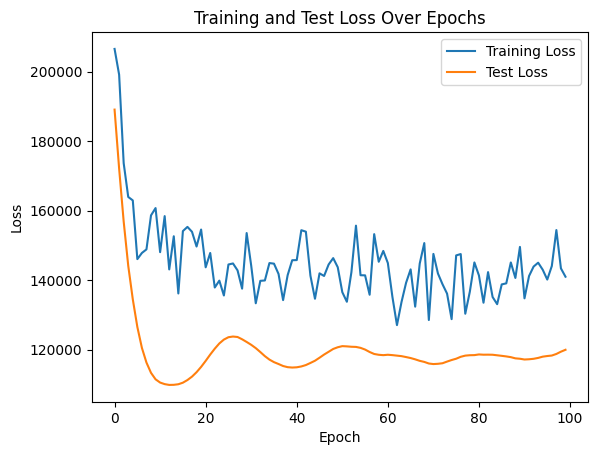

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()